In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Make a plot with the photometry, spectra and fits to both stars

In [2]:
gaia = glob.glob('data/*gaia*vot')
print(gaia)
# gaia = 

['data/g203_gaiadr3_sampled_mean_spectra_1355264565043431040.vot', 'data/gj207_gaiadr3_sampled_mean_spectra_3223516063958808064.vot', 'data/wolf1120_gaia_spectrum.vot', 'data/lhs1817_gaia_spectrum.vot']


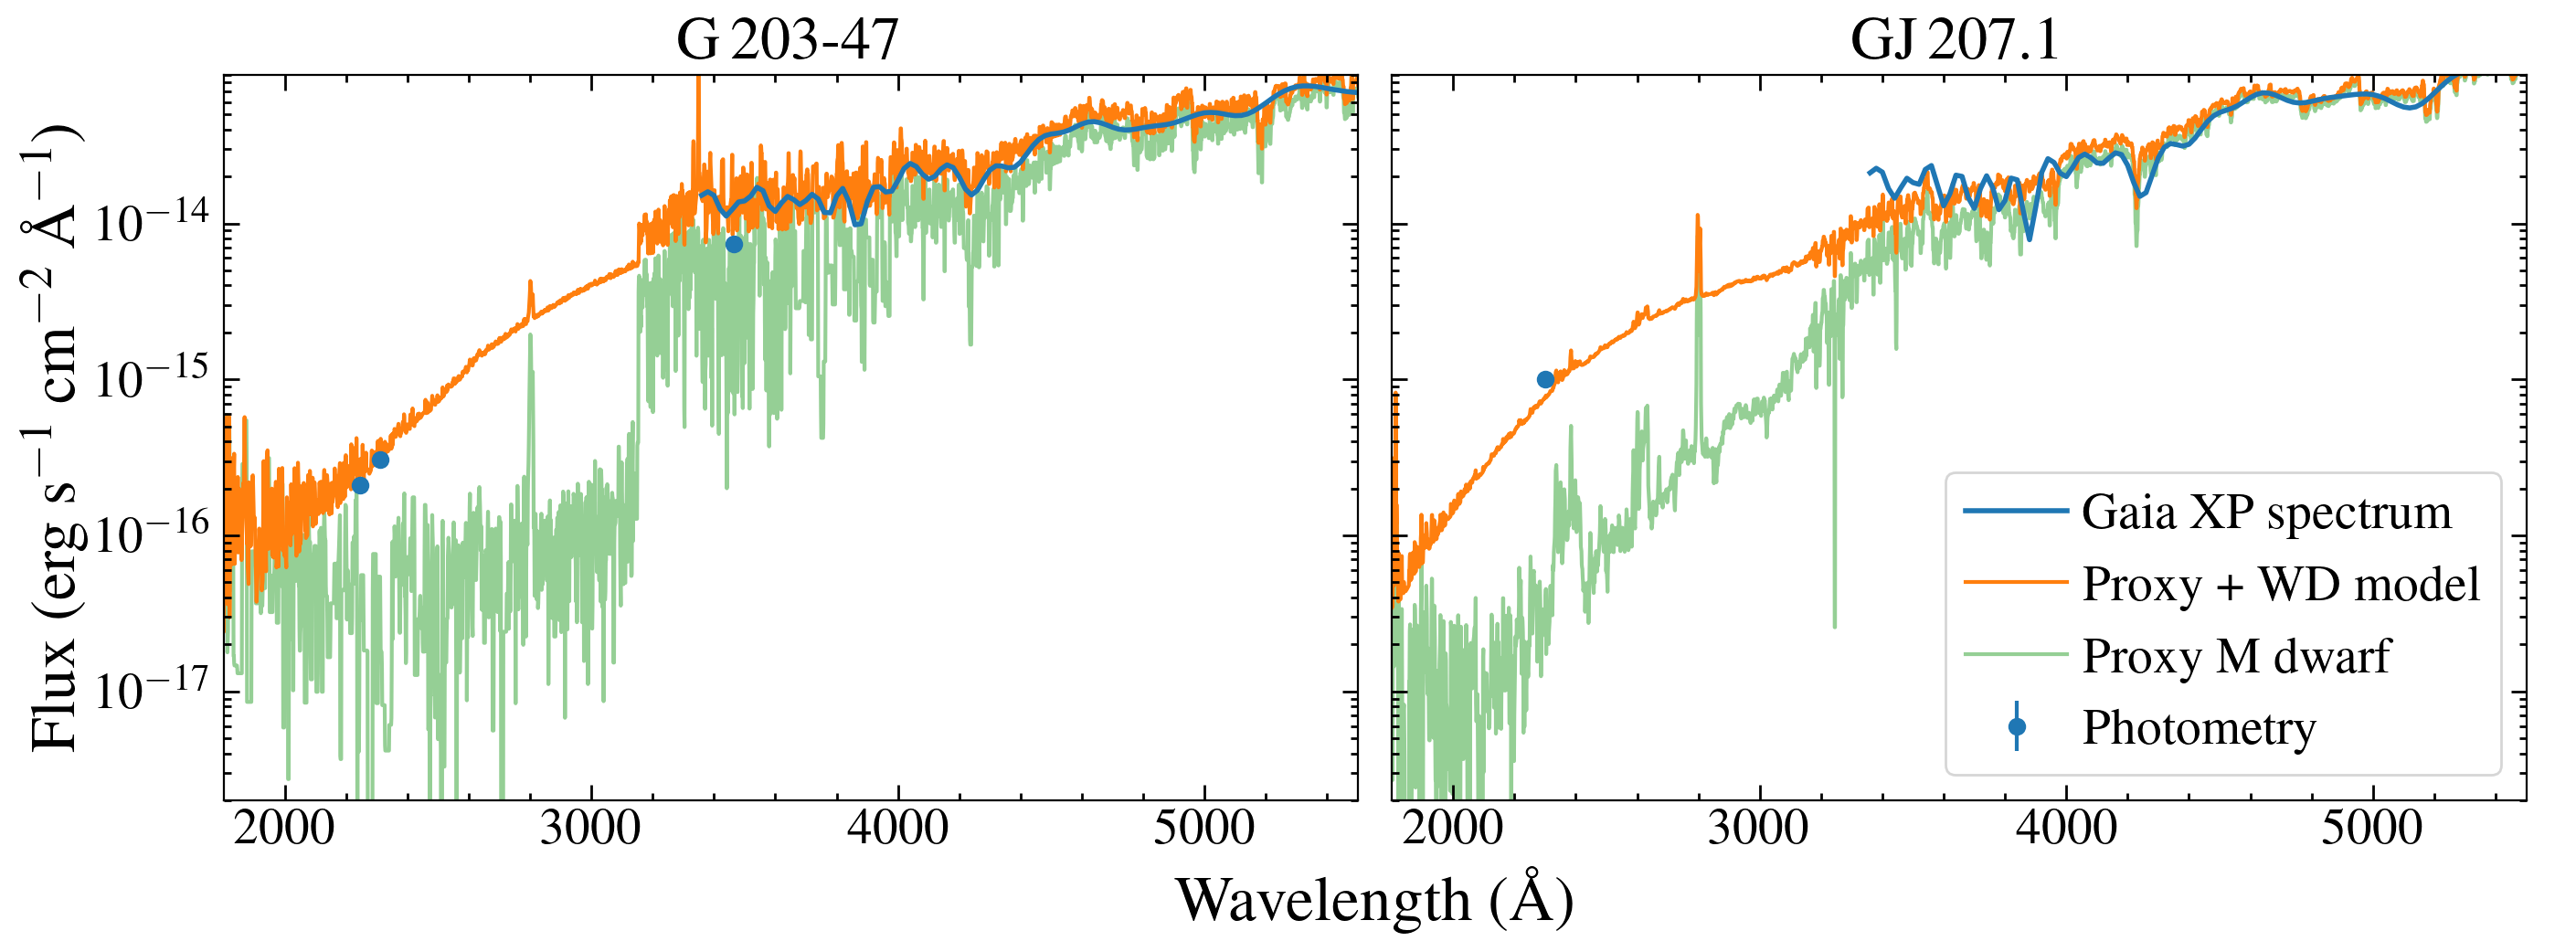

In [3]:
fig, ax = plt.subplots(ncols =2, sharex=True, figsize=(14, 5.5))

ax[0].set_title('G\,203-47')
ax[1].set_title('GJ\,207.1')

gaia = glob.glob('data/*gaia*vot')
# print(gaia)
for i, spec in enumerate(gaia[0:2]):
    # print(spec)
    data = Table.read(spec)
    mask = data['type'] == 'XP'
    ax[i].plot(data['wavelength'][mask]*10, data['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA), 
               label = 'Gaia XP spectrum', c='C0', lw=2)
    
#g203
phot_w = [3465, 2246, 1530, 2310]
phot_f = [7.411776e-15, 2.0942781e-16, 8.96470249e-17, 3.06191581e-16]
phot_e = [1.7897673e-16, 1.3159324943194897e-17, 3.45781382e-17, 2.69673319e-17]
ax[0].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', c='C0')

#gj207
# 2300.79 1.0049178765233773e-15 1.0487355277243325e-16
phot_w = [2300.79]
phot_f = [1.0049178765233773e-15]
phot_e = [1.0487355277243325e-16]
ax[1].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', label ='Photometry', c='C0')

mods = ['g203_model.dat', 'gj207_model.dat']
for i, mod in enumerate(mods):
    mw, mf = np.loadtxt(mod, unpack=True)
    ax[i].plot(mw, mf, zorder=-5, label = 'Proxy + WD model', c='C1')

proxys = ['/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/L-980-5/hlsp_muscles_multi_multi_l-980-5_broadband_v24_adapt-const-res-sed.fits',
         '/media/david/2tb_ext_hd/hddata/carmenes_binary//gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits']

scales = [3.1149330983671675, 0.36117578882221896/1.4691682547408482]

for i, proxy in enumerate(proxys):
    data = fits.getdata(proxy, 1)
    ax[i].plot(data['WAVELENGTH'], data['FLUX']*scales[i], label = 'Proxy M dwarf', alpha=0.5, zorder=-10, c='C2')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[1].legend(frameon=True, loc=4)
ax[0].set_xlim(1800, 5500)
ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)
ax[0].set_ylim(2e-18, 9e-14)
ax[1].set_ylim(2e-18, 9e-14)
ax[1].set_yticklabels([])

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.xlabel('Wavelength (\AA)', size=25)
plt.tight_layout()
plt.subplots_adjust(wspace=0.03, bottom=0.15, left=0.09, right=0.99)

fig.savefig('plots/both_spec_model.pdf')

New plot with all four targets.

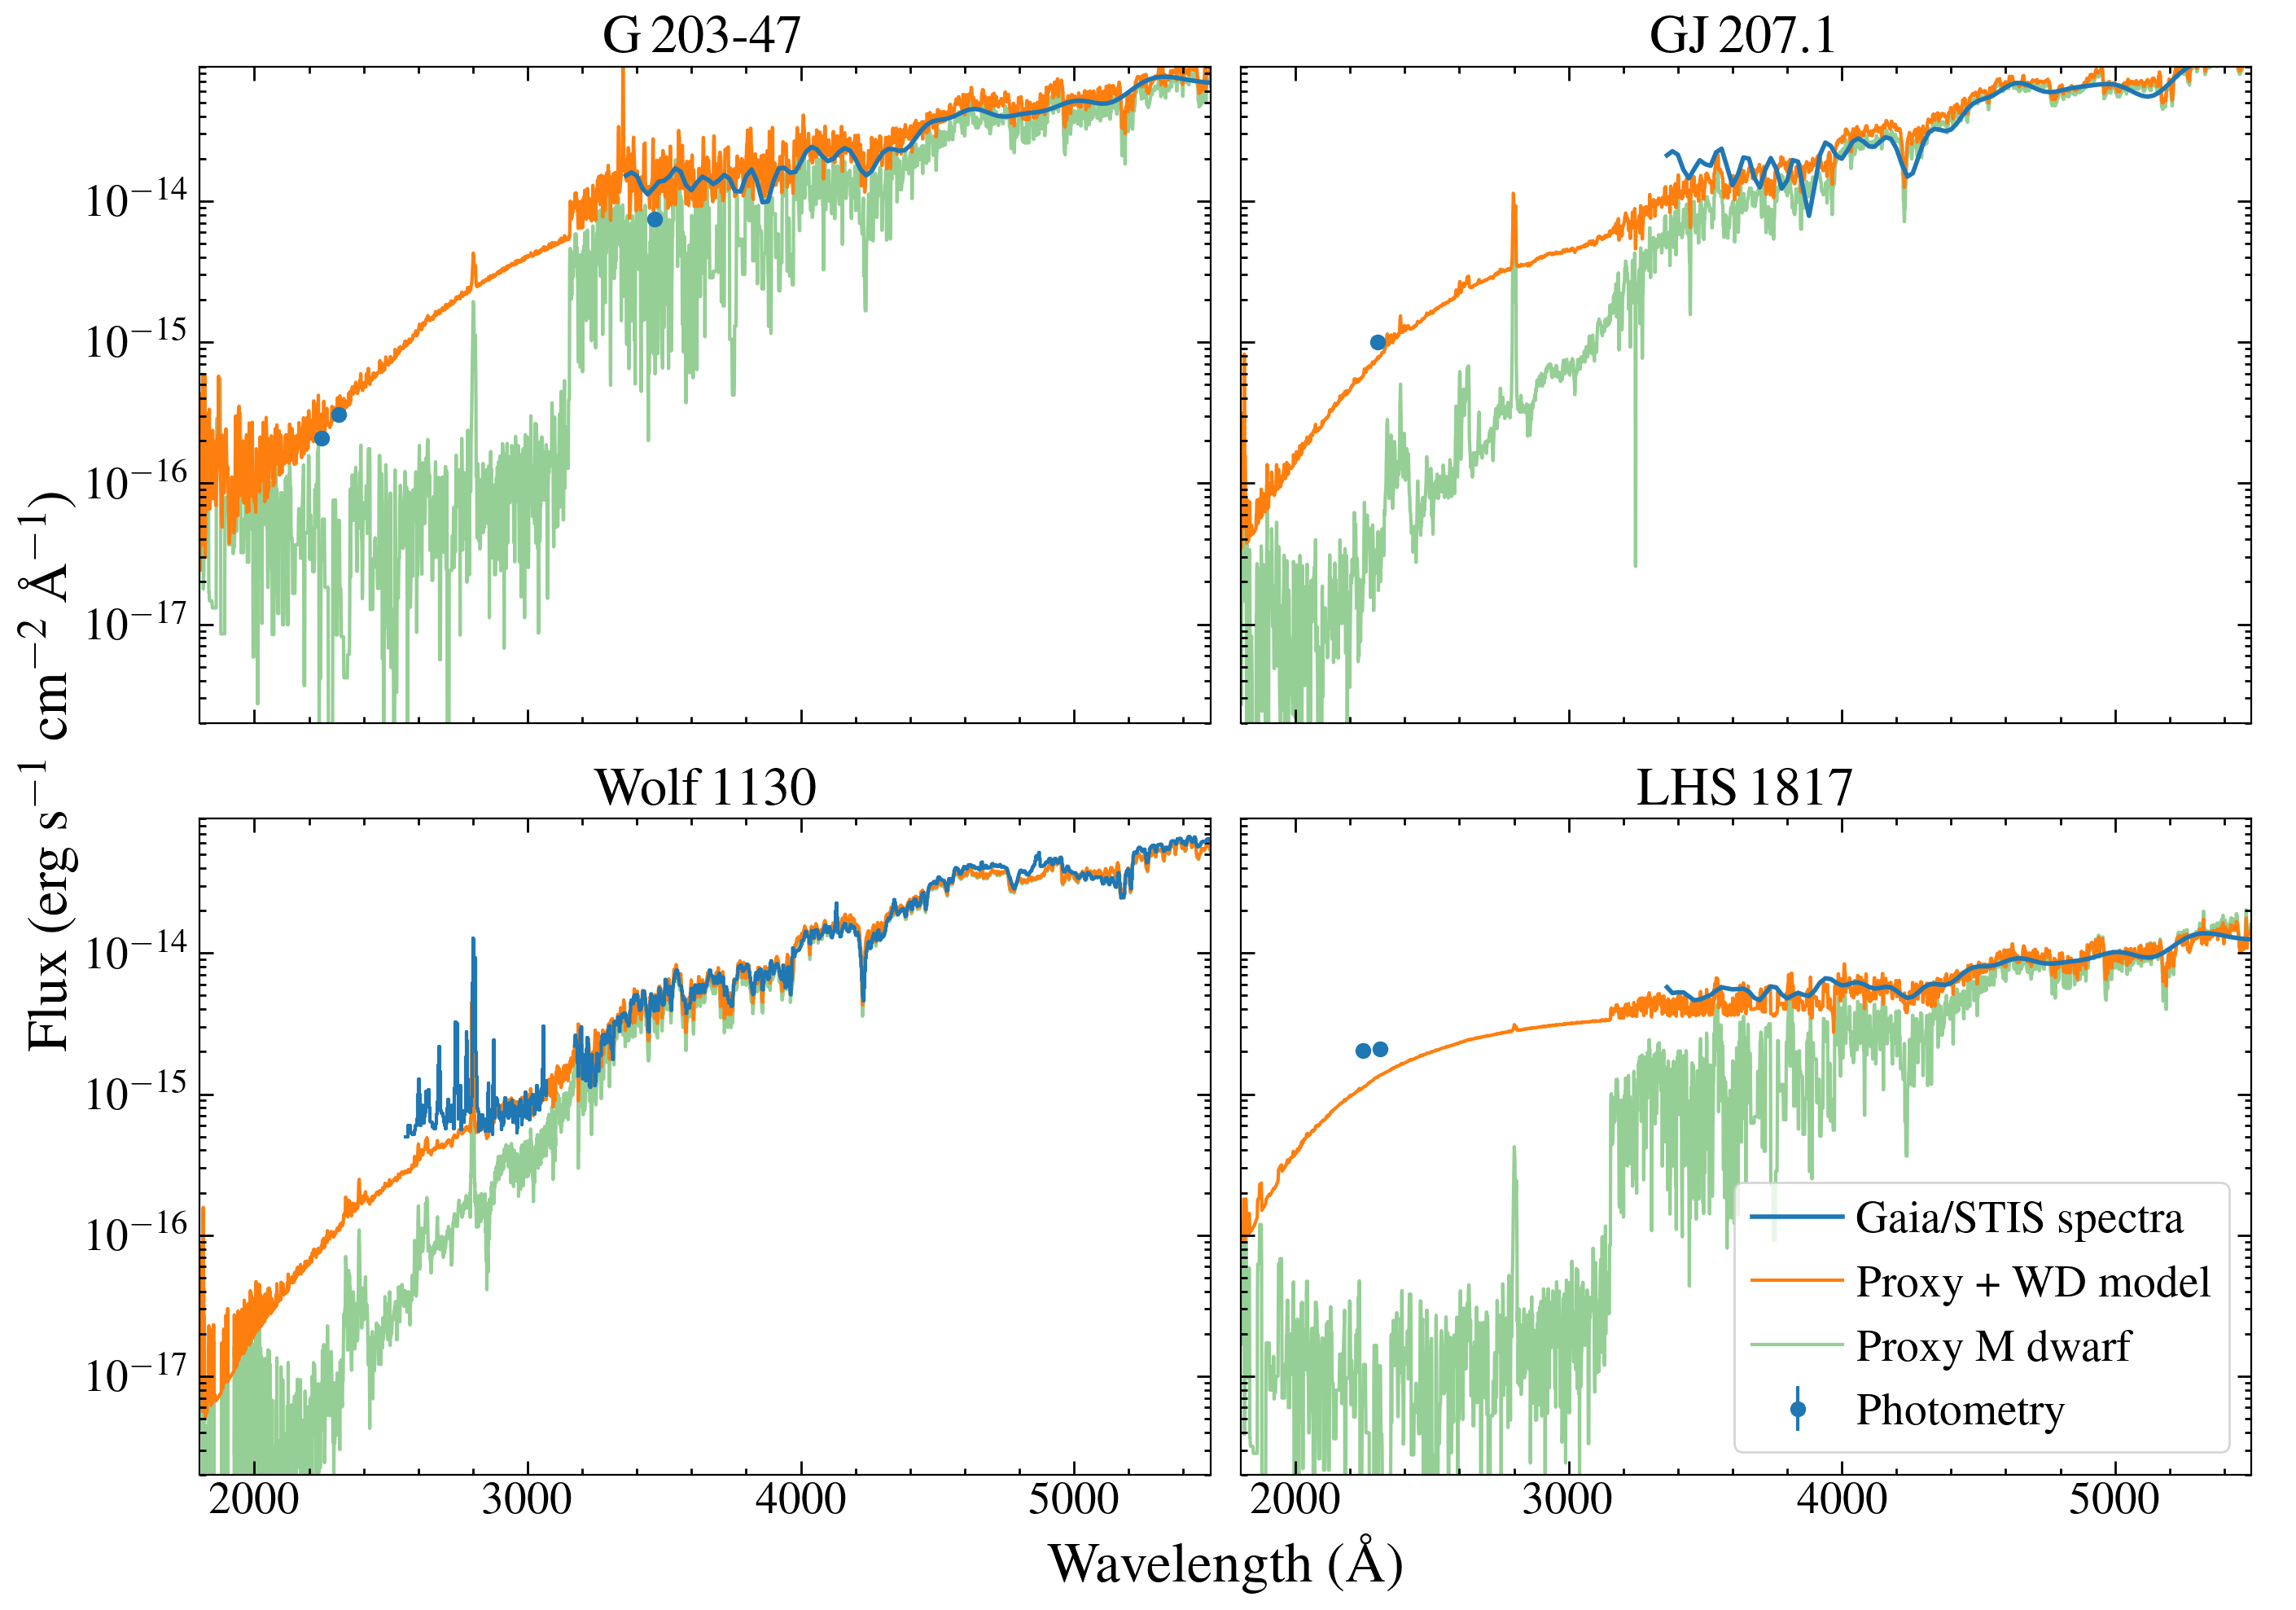

In [4]:
fig, axes = plt.subplots(ncols =2, nrows=2, sharex=True, figsize=(14, 11))

ax = axes.flat

ax[0].set_title('G\,203-47')
ax[1].set_title('GJ\,207.1')
ax[2].set_title('Wolf\,1130')
ax[3].set_title('LHS\,1817')

gaia = glob.glob('data/*gaia*vot')
# print(gaia)
for i, spec in enumerate(gaia):
    # print(spec)
    data = Table.read(spec)
    mask = data['type'] == 'XP'
    if i != 2:
        ax[i].plot(data['wavelength'][mask]*10, data['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA), 
               label = 'Gaia/STIS spectra', c='C0', lw=2)
    
#g203
phot_w = [3465, 2246, 1530, 2310]
phot_f = [7.411776e-15, 2.0942781e-16, 8.96470249e-17, 3.06191581e-16]
phot_e = [1.7897673e-16, 1.3159324943194897e-17, 3.45781382e-17, 2.69673319e-17]
ax[0].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', c='C0')

#gj207
# 2300.79 1.0049178765233773e-15 1.0487355277243325e-16
phot_w = [2300.79]
phot_f = [1.0049178765233773e-15]
phot_e = [1.0487355277243325e-16]
ax[1].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', label ='Photometry', c='C0')

#wolf1130
path = '/media/david/2tb_ext_hd/hddata/carmenes_binary/wolf1130/hst/hlsp/'
data = fits.getdata('{}hlsp_lowlib_hst_stis_lhs482_g230lb-g430l-g750l_v1.0_spect.fits'.format(path), 1)
sw, sf, se = data['Wavelength'], data['Scattered Light & Slit Offcenter Corrected'], data['Error_scattered_slit']
ndata = Table.read('data/wolf1130_nuv.ecsv')
nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
truemask = ((nf/ne) > 3) & (nw > 2550)
nw, nf, ne = nw[truemask], nf[truemask], ne[truemask]
nf = convolve(nf,  Box1DKernel(2))
ne = convolve(ne,  Box1DKernel(2))/2**0.5
smask = (sw > nw[-1]+100)

ax[2].step(nw, nf, c='C0', where='mid')
sf = convolve(sf,  Box1DKernel(2))
se = convolve(se,  Box1DKernel(2))/(2**0.5)

ax[2].step(sw[smask], sf[smask], c='C0', where='mid')



#lhs1817
phot_w = [1530, 2246, 2310]
phot_f = [4.187085227729264e-16, 2.0435403e-15, 2.096930971169549e-15]
phot_e = [5.2457646901586435e-17, 5.163791e-17, 3.4075713842507104e-17]
ax[3].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none',  c='C0', label ='Photometry')


mods = ['g203_model.dat', 'gj207_model.dat', 'wolf1130_model.dat', 'lhs1817_model.dat']
for i, mod in enumerate(mods):
    mw, mf = np.loadtxt(mod, unpack=True)
    if i < 3:
        ax[i].plot(mw, mf, zorder=-5, label = 'Proxy + WD model', c='C1')
    else:
        ax[i].plot(mw, mf*0.5, zorder=-5, label = 'Proxy + WD model', c='C1')
       
proxys = ['/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/L-980-5/hlsp_muscles_multi_multi_l-980-5_broadband_v24_adapt-const-res-sed.fits',
         '/media/david/2tb_ext_hd/hddata/carmenes_binary//gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits', 
         '/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/gj832/hlsp_muscles_multi_multi_gj832_broadband_v22_adapt-var-res-sed.fits',
         '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/L-980-5/hlsp_muscles_multi_multi_l-980-5_broadband_v24_adapt-const-res-sed.fits']

scales = [3.1149330983671675, 0.36117578882221896/1.4691682547408482, 0.08839274943323047*0.5, 0.6787314534519303]

for i, proxy in enumerate(proxys):
    data = fits.getdata(proxy, 1)
    ax[i].plot(data['WAVELENGTH'], data['FLUX']*scales[i], label = 'Proxy M dwarf', alpha=0.5, zorder=-10, c='C2')

# g230l = [1570,3180]
# for i in range(len(ax)):
#     [ax[i].axvline(line, ls='--', c='C3', alpha=0.5) for line in g230l] 
    
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')
ax[3].legend(frameon=True, loc=4)
ax[0].set_xlim(1800, 5500)
ax[0].set_ylim(2e-18, 9e-14)
ax[1].set_ylim(2e-18, 9e-14)
ax[2].set_ylim(2e-18, 9e-14)
ax[3].set_ylim(2e-18, 9e-14)
ax[1].set_yticklabels([])
ax[3].set_yticklabels([])

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25, labelpad=25)

plt.tight_layout()
plt.subplots_adjust(wspace=0.03, bottom=0.15, left=0.09, right=0.99)

fig.savefig('plots/four_spec_model.pdf')

Make SN plots from etc runs  
G203-47 https://etc.stsci.edu/etc/results/STIS.sp.1845847/  
GJ207.1 https://etc.stsci.edu/etc/results/STIS.sp.1845848/  
Wolf 1130 https://etc.stsci.edu/etc/results/STIS.sp.1845849/  
LHS 1817 https://etc.stsci.edu/etc/results/STIS.sp.1845850/


In [5]:
# sns = glob.glob('etc/*sn*')
sns = ['etc/g203_sn.csv', 'etc/gj207_sn.csv','etc/wolf_1130_sn.csv','etc/lhs1817_sn.csv']


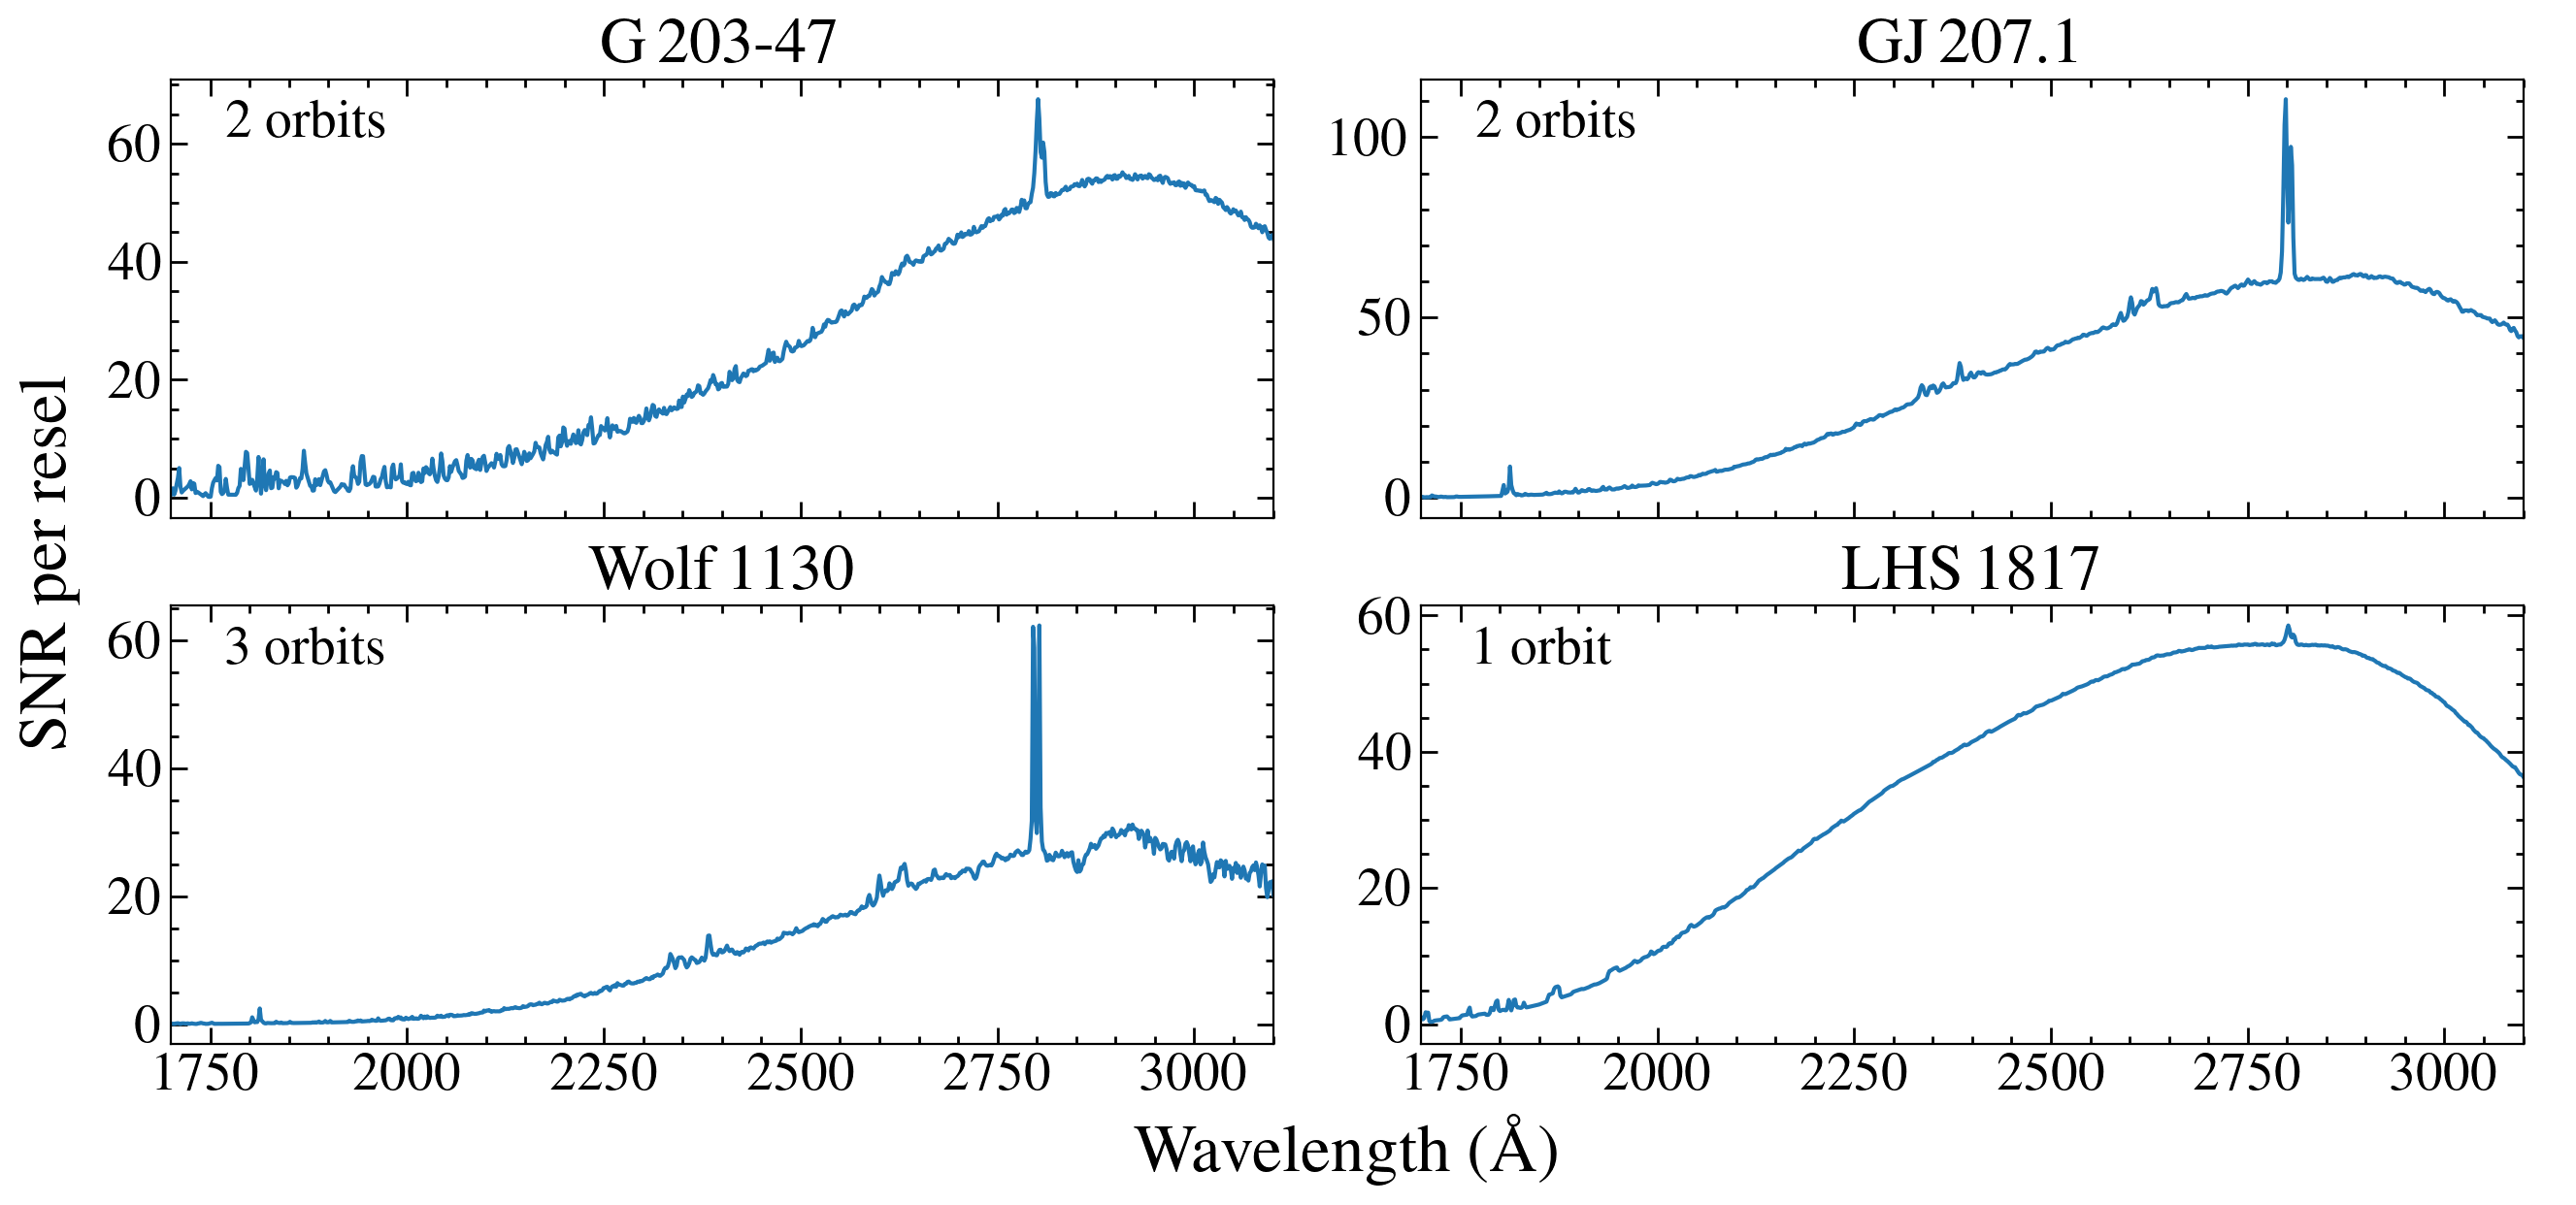

In [6]:
fig, axes = plt.subplots(ncols =2, nrows=2, sharex=True, figsize=(14, 7))

etcs = ['etc/g203_sn.csv', 'etc/gj207_sn.csv','etc/wolf_1130_sn.csv','etc/lhs1817_sn.csv']

orbs = [2,2,3,1]
pl = ['s', 's', 's', '']

ax = axes.flat

ax[0].set_title('G\,203-47')
ax[1].set_title('GJ\,207.1')
ax[2].set_title('Wolf\,1130')
ax[3].set_title('LHS\,1817')

for i, etc in enumerate(etcs):
    data = Table.read(etc)
    w, targ, tot = data['wavelength'], data['target_counts'], data['total_counts']
    N= (tot*0.5)**0.5
    sn = targ/N
    mask = sn > 0
    ax[i].plot(w[mask], sn[mask])
    ax[i].set_xlim(1700, 3100)
    ax[i].annotate('{} orbit{}'.format(orbs[i],pl[i]), (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
    
    # if i == 2:
    #     ax[i].plot(sw, sf/se)
    
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('SNR per resel', size=25, labelpad=5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

# fig.savefig('plots/sn_calcs.pdf')

In [7]:
from scipy import signal

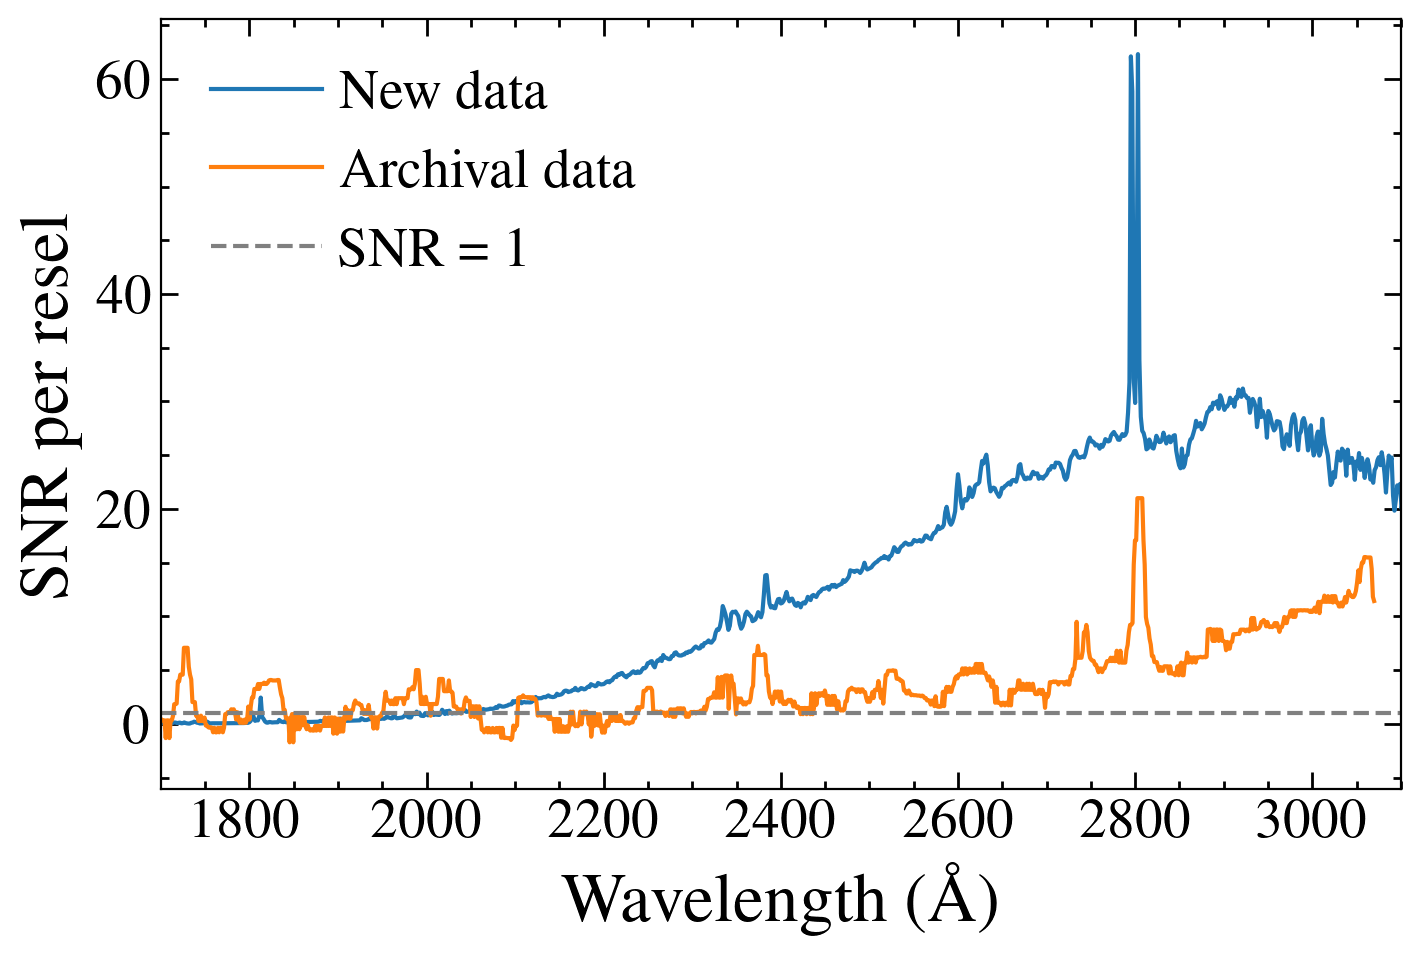

In [8]:
fix, ax = plt.subplots(figsize=(8, 5))
data = Table.read(etcs[2])
w, targ, tot = data['wavelength'], data['target_counts'], data['total_counts']
N= (tot*0.5)**0.5
sn = targ/N
mask = sn > 0
# sn = signal.medfilt(sn, 5)

ax.plot(w[mask], sn[mask], label='New data')
ax.set_xlim(1700, 3100)

nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
# truemask = ((nf/ne) > 3) & (nw > 2550)
# nw, nf, ne = nw[truemask], nf[truemask], ne[truemask]
# nf = convolve(nf,  Box1DKernel(2))
# ne = convolve(ne,  Box1DKernel(2))/2**0.5

# ax.annotate('{} orbit{}'.format(orbs[i],pl[i]), (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
sn = nf/ne


# sn = convolve(sn,  Box1DKernel(2))
sn = signal.medfilt(sn*(2**0.5), 15)

ax.plot(nw, sn, label = 'Archival data')

ax.axhline(1, ls='--', c='0.5', label = 'SNR = 1')
# ax.annotate('S/N=1', (0.97, ))

ax.legend()
ax.set_xlabel('Wavelength (\AA)', size=25)
ax.set_ylabel('SNR per resel', size=25, labelpad=5)
fig.savefig('plots/wolf1130_snr_comp.pdf')

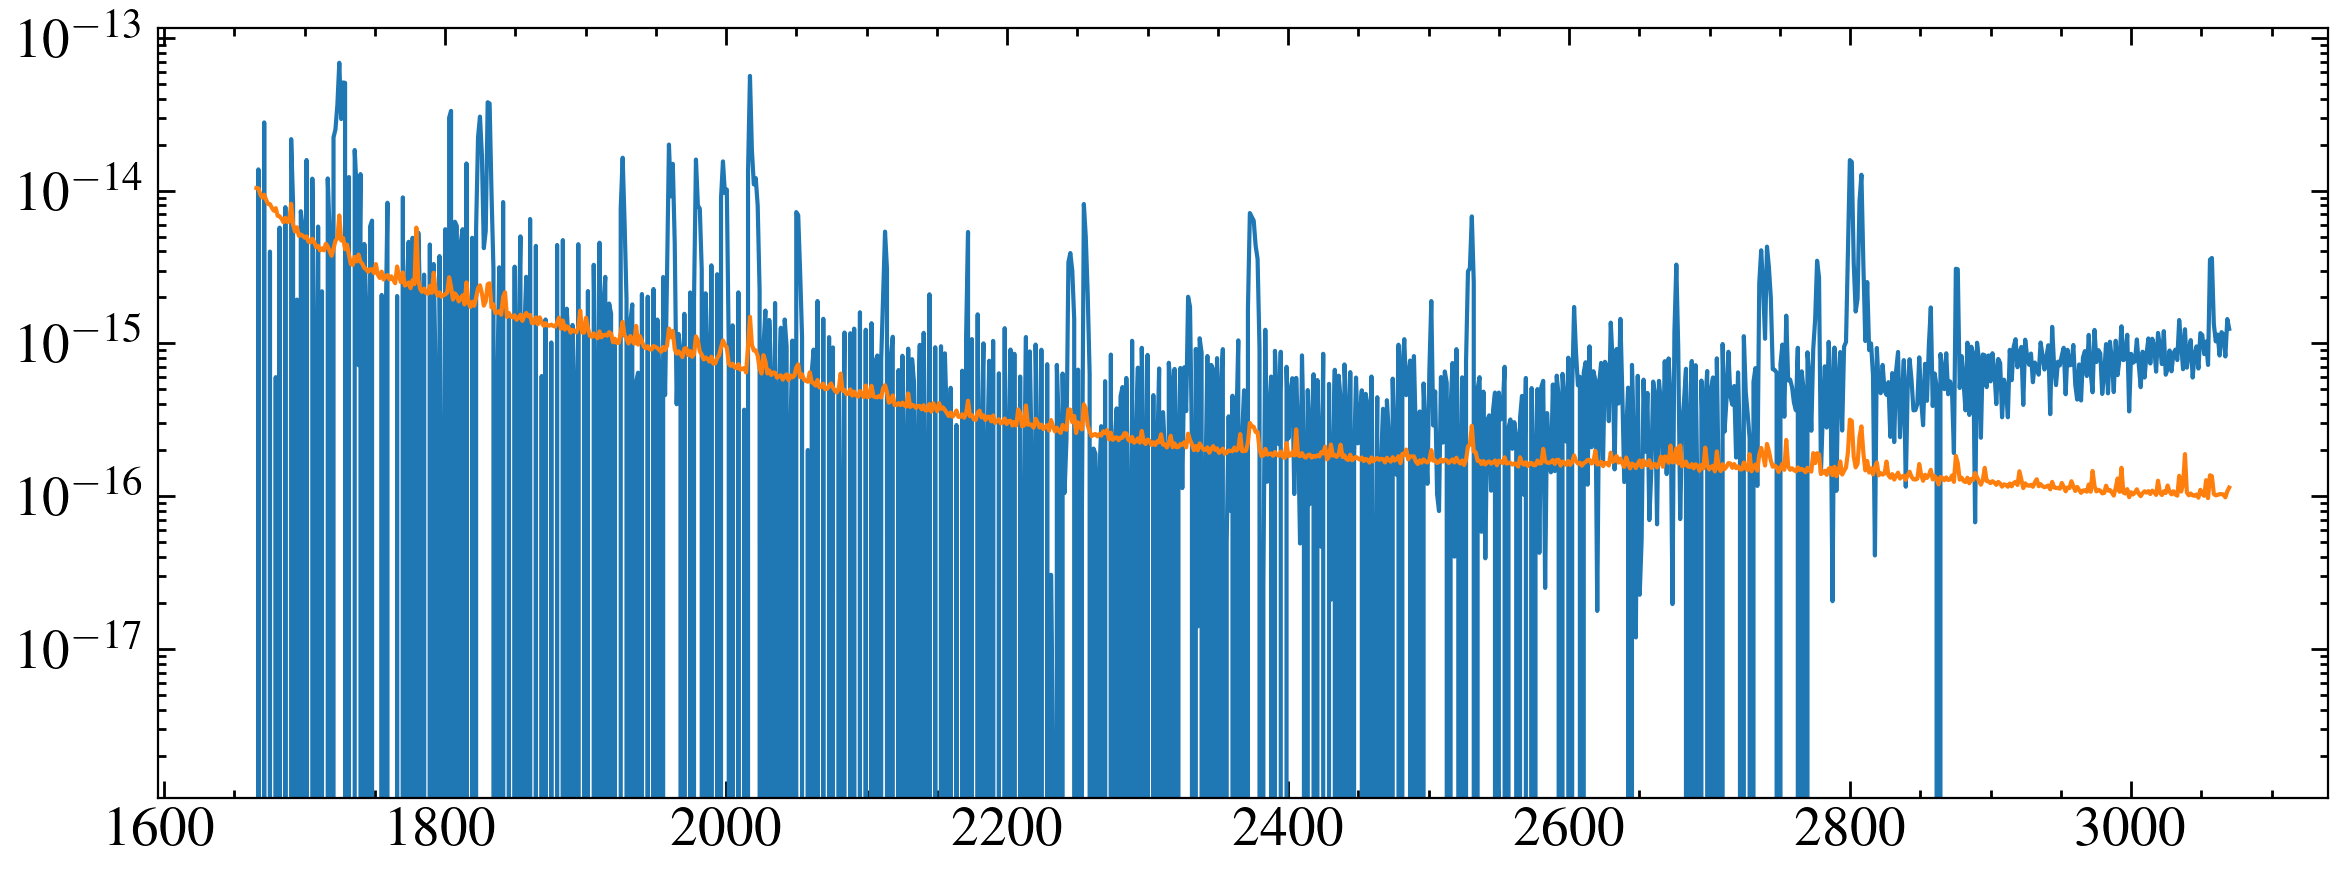

In [9]:
plt.plot(nw, nf)
plt.plot(nw, ne)

# plt.plot(nw, nf/ne)

plt.yscale('log')

Make a nice M dwarf + wd model plot - use GJ 207.1

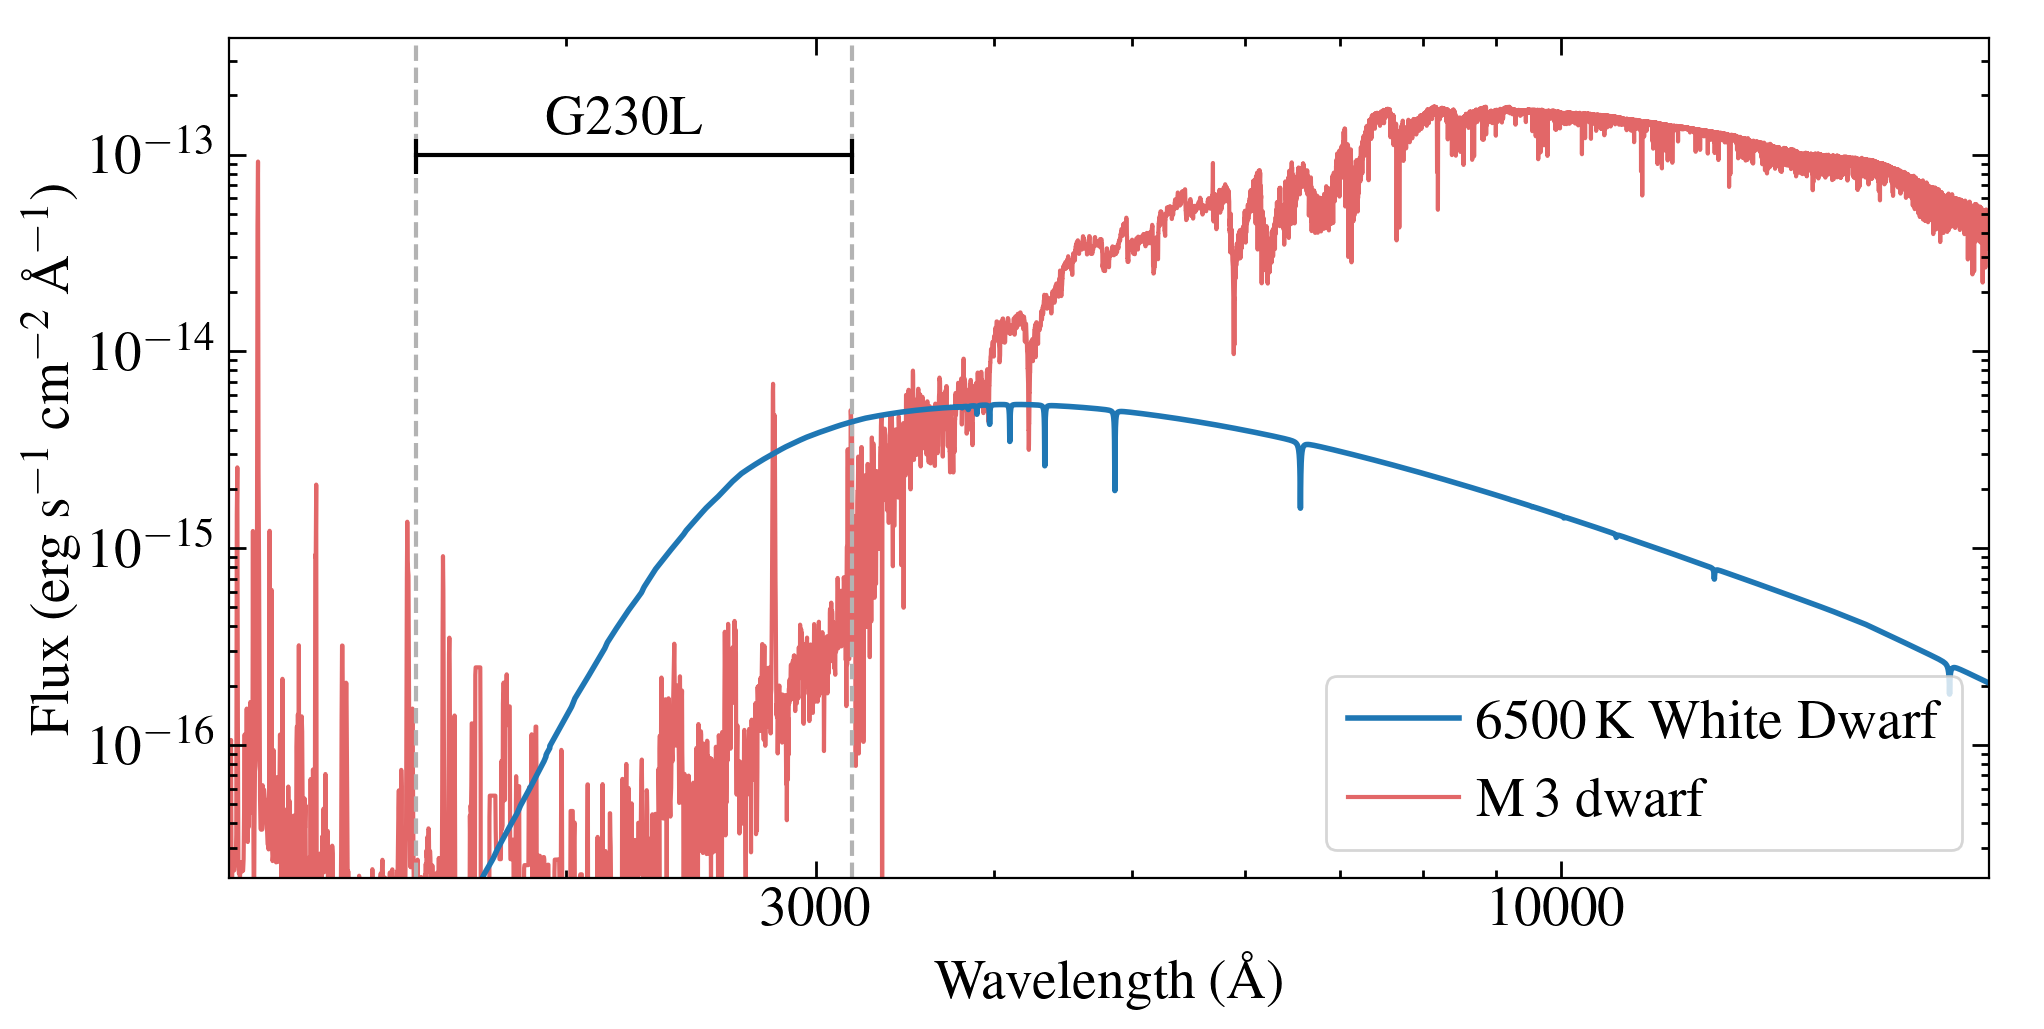

In [20]:
fig, ax = plt.subplots(ncols =1, sharex=True, figsize=(10, 5))

# ax[0].set_title('G\,203-47')
# ax[1].set_title('GJ\,207.1')

# gaia = glob.glob('data/*gaia*vot')
# # print(gaia)
# for i, spec in enumerate(gaia[0:2]):
#     # print(spec)
#     data = Table.read(spec)
#     mask = data['type'] == 'XP'
#     ax[i].plot(data['wavelength'][mask]*10, data['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA), 
#                label = 'Gaia XP spectrum', c='C0', lw=2)
    
# #g203
# phot_w = [3465, 2246, 1530, 2310]
# phot_f = [7.411776e-15, 2.0942781e-16, 8.96470249e-17, 3.06191581e-16]
# phot_e = [1.7897673e-16, 1.3159324943194897e-17, 3.45781382e-17, 2.69673319e-17]
# ax[0].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', c='C0')

# # #gj207
# # # 2300.79 1.0049178765233773e-15 1.0487355277243325e-16
# # phot_w = [2300.79]
# # phot_f = [1.0049178765233773e-15]
# # phot_e = [1.0487355277243325e-16]
# # ax[1].errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none', label ='Photometry', c='C0')

mod = 'gj207_model.dat'
mw, mf = np.loadtxt(mod, unpack=True)
# ax.plot(mw, mf, zorder=-5, label = 'Proxy + WD model', c='C1')

wdmod = '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06500_800.dk.dat.txt'
wdw, wdf = np.loadtxt(wdmod, unpack=True)
wdscale = 3.3434064163686346e-22
ax.plot(wdw, wdf*wdscale, c='C0', lw=2, label = '6500\,K White Dwarf')


# proxy  = '/media/david/2tb_ext_hd/hddata/carmenes_binary//gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits'
proxy = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_multi_multi_gj674_broadband_v24_adapt-const-res-sed.fits'

scale = (1000/(219.64625138839503*15.87))**2

data = fits.getdata(proxy, 1)

bp = [1570,3180]
yline = 1e-13
ax.errorbar(np.array(bp), np.array([yline, yline]), c='k', yerr=2e-14)
ax.annotate('G230L', (2200, yline*1.1), ha='center', va='bottom')
[ax.axvline(line, ls='--', c='0.7', zorder=-1) for line in bp]

ax.plot(data['WAVELENGTH'], data['FLUX']*scale, label = 'M\,3 dwarf', alpha=0.7, zorder=-10, c='C3')


ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(frameon=True, loc=4)
ax.set_xlim(1161, 19999)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
ax.set_ylim(2.1e-17, 3.9e-13)

ax.set_xticks([3e3, 1e4], [3000, 10000])

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.xlabel('Wavelength (\AA)', size=20)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15, left=0.11, right=0.99, top=0.99)

fig.savefig('plots/m3_eg_spec_model.pdf')